# Testing KERAS classification with MLP

In [1]:
from fastespy.mlkeras.evaluation import SplitData, plot_metric, plot_sig_vs_thr, get_sig_bkg_rate_eff, get_tp_fp_fn, learning_curve, SignificanceMetric
from fastespy.mlkeras import models
from fastespy.ml import MLHyperParTuning
from fastespy.readpydata import convert_data_to_ML_format
from fastespy import feldman_cousins as fc
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import glob
import os
import tempfile
import logging
import numpy as np
import tqdm
import time
from pathlib import PosixPath
from fastespy.analysis import init_logging
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
sys.path.append("/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

## Read data 

In [7]:
path = "/Users/manuelmeyer/Documents/TESData/IntrinsicsData_NewSetup/" # May 2021 data
prefix = "IntrinsicsData_NewSetup"

path = "/Users/manuelmeyer/Documents/TESData/August2020/" # May 2021 data
prefix = "August2020"

#path = "/Users/manuelmeyer/Python/TESdata/data-01152021//" # August 2020 data
#prefix = "data_august2020"

in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

if not len(files):
    path = "/Users/manuelmeyer/Python/TESdata/data-05122021/"
    in_dir = PosixPath(path)
    files = glob.glob(os.path.join(path, '*.npy'))
    print(len(files))

17


In [8]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3247362142.py:   3 --- INFO: Using files:
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHz-light-000-fit.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelme

Do a log transform

In [9]:
X_log, y_log = MLHyperParTuning.transform_data_log(X.copy(), y.copy(), feature_names)

Discarded 234 triggers in log transform


/Users/manuelmeyer/Python/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


Get a split of the data (will be repeated later on):

In [10]:
sd = SplitData(X_log, y_log, n_splits=5, stratify=True, random_state=42)

In [11]:
i_split = 0
#X_train, X_test, y_train, y_test = sd.get_split(i_split)
X_train, X_val, y_train, y_val = sd.get_split_with_test_set(m=i_split, n=0)

Normalize the data

In [12]:
# normalize the input data
normalizer = Normalization(axis=-1)

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_val = normalizer(X_val)
X_test = normalizer(sd.X_test)

### Define the model

In [13]:
initial_bias, initial_loss = models.initial_output_bias(y_train)
print(initial_bias, initial_loss)

[-3.60731045] [0.12202658]


In [14]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

In [15]:
sm = SignificanceMetric(N_tot=y_train.size + y_val.size + sd.y_test.size,
                        t_obs=t_tot_hrs * 3600.,
                        #dtype=tf.float
                       )
metrics = list(models.metrics)
metrics.append(sm)

In [16]:
model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4,
                              metrics=metrics
                             )

Initial predictions

In [17]:
model.predict(X_train[10:]), y_train.sum() / y_train.size

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 13:46:41.819860: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-01 13:46:41.824139: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x286c67ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(array([[0.02566463],
        [0.02572925],
        [0.02583458],
        ...,
        [0.02345813],
        [0.02599524],
        [0.02506048]], dtype=float32),
 0.026408382631558598)

In [18]:
results = model.evaluate(X_train, y_train, verbose=0, return_dict=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b15a2280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <bound method SignificanceMetric.update_state of <fastespy.mlkeras.evaluation.SignificanceMetric object at 0x1071567c0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <bound method SignificanceMetric.result of <fastespy.mlkeras.evaluation.SignificanceMetric object at 0x1071567c0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
print(results)

{'loss': 0.12253886461257935, 'tp': 0.0, 'fp': 0.0, 'tn': 25180.0, 'fn': 683.0, 'accuracy': 0.9735916256904602, 'precision': 0.0, 'recall': 0.0, 'auc': 0.3863910734653473, 'prc': 0.020943909883499146, 'significance': 0.0}


In [20]:
results['loss'], initial_loss

(0.12253886461257935, array([0.12202658]))

Save the inital weights

In [21]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights_{n_layers}_{n_nodes}')
model.save_weights(initial_weights)

### Train the full model

In [22]:
model.summary()
model.load_weights(initial_weights)

Model: "mlp_binary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense4 (Dense)               (None, 100)               1

In [23]:
keras.utils.plot_model(model, "model.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
EPOCHS = 200
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

baseline_history = models.train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, X_val=X_val, y_val=y_val)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b13bfb80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 13:47:08.345694: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 13:47:08.345805: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 13:47:08.345818: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 13:47

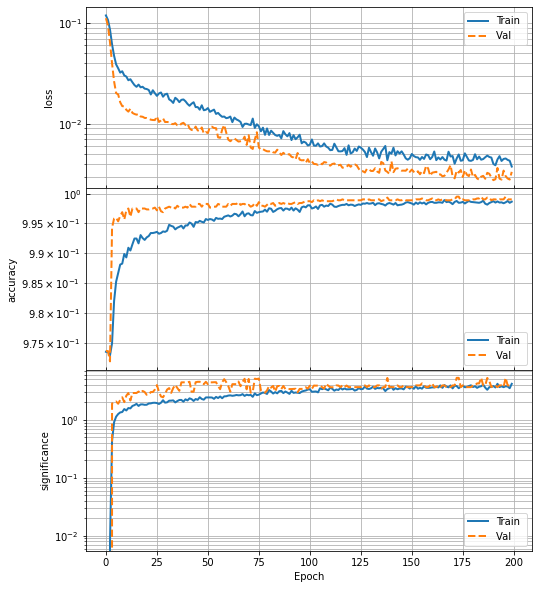

In [25]:
fig=plt.figure(figsize=(8,10))
ax = plt.subplot(311)
plot_metric(baseline_history, ax=ax, lw=2)
ax.tick_params(direction='in', labelbottom=False)
ax.set_xlabel("")
ax.grid(which='both')
plt.legend()

ax = plt.subplot(312)
plot_metric(baseline_history, ax=ax, metric='accuracy', lw=2)
ax.tick_params(direction='in', labelbottom=False)
ax.set_xlabel("")
ax.grid(which='both')
plt.legend()

ax = plt.subplot(313)
plot_metric(baseline_history, ax=ax, metric='significance', lw=2)
ax.grid(which='both')
plt.legend()

plt.subplots_adjust(hspace=0.)

plt.savefig(f"{prefix:s}_metrics_vs_epochs.png")

In [26]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
print(results)

{'loss': 0.0027402015402913094, 'tp': 680.0, 'fp': 16.0, 'tn': 25164.0, 'fn': 3.0, 'accuracy': 0.9992653727531433, 'precision': 0.977011501789093, 'recall': 0.9956076145172119, 'auc': 0.99991774559021, 'prc': 0.9957250952720642, 'significance': 4.281110763549805}


### Evaluate metrics on training and validation set

In [27]:
thr = 0.5
y_pred = model.predict(X_train)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

4.281110633677952 1.3409048501547276e-05 0.9956076134699854


In [28]:
thr = 0.5
y_pred = model.predict(X_val)
#class_pred_test, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=thr)


sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

3.702799436482806 2.0112795085573605e-05 1.0


### Retrain with class weights

In [29]:
# weighting following
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# original: increasing weight for class 1:
# false negatives go down, false positives go up
# significance goes down
weight_for_0 = 1 / (y.size - y.sum()) * (y.size / 2.)
weight_for_1 = 1 / y.sum() * (y.size / 2.)

# inverting weights: fp down, fn up, significance up!
power = 1.
weight_for_0 = 1. / (1 / (y.size - y.sum()) * (y.size / 2.))**power
weight_for_1 = 1. / (1 / y.sum() * (y.size / 2.))**power

print('Weight for class 0: {:.3f}'.format(weight_for_0))
print('Weight for class 1: {:.3f}'.format(weight_for_1))



Weight for class 0: 1.948
Weight for class 1: 0.052


In [30]:
use_class_weights = False

if use_class_weights:
    model.load_weights(initial_weights)
    print({0: weight_for_0, 1: weight_for_1})

    class_weight_history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val), 
        verbose=0,
        class_weight={0: weight_for_0, 1: weight_for_1},
    )

In [31]:
if use_class_weights:
    result = model.evaluate(X_val, return_dict=True)
    print(result)
    
    plot_metric(class_weight_history)
    plt.legend()
    
    plot_metric(class_weight_history, metric='significance')
    plt.legend()
    
    thr = 0.5
    y_pred = model.predict(X_train)

    sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
    print(sig, bkg_rate, eff)
    
    y_pred = model.predict(X_val)

    sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
    print(sig, bkg_rate, eff)

results as function of power in weight definition for May 2021 data

| power | weight 0 | weight 1 | sig val | bkg rate (Hz) val | eff val | 
|---|---|---|---|---|---|
| 0 | 1 | 1 | 1.95 | 8.20e-5 | 0.99 | 
| 1 | 1.53 | 0.47 | 2.26 | 5.7e-5 | 0.97 | 
| 2 | 2.33 | 0.22 | 2.34 | 4.99e-5 | 0.95 | 
| 3 | 3.558 | 0.106 | 2.91 | 2.49e-5 | 0.86 |
| 4 | 5.43 | 0.05 | 3.73 | 1.07e-5 | 0.80 | 
| 5 | 8.29 | 0.02 | 0. | 0. | 0. | 

As can be seen, class weights have similar effet as setting the threshold to a higher value than 0.5. FP goes down, TP also down. 

For August 2020 data:

| power | weight 0 | weight 1 | sig val | bkg rate (Hz) val | eff val | 
|---|---|---|---|---|---|
| 0 | 1 | 1 | 3.97 | 1.68e-05 | 1.0 | 
| 1 | 1.95 | 0.05 | 4.27 | 6.7e-6 | 0.75 | 
| 1.2 | 2.225 | 0.03 | 5.18 | 3.35e-6 | 0.75 | 
| 1.5 | 2.72 | 0.01 | 0 | 0| 0. | 
| 2 | 3.97 | 0.003 | 0. | 0. | 0. | 


## Significance as function of threshold

For validation set

Max significance: 6.02 for threshold 0.9989 background rate 0.00e+00 and analysis efficiency 0.35


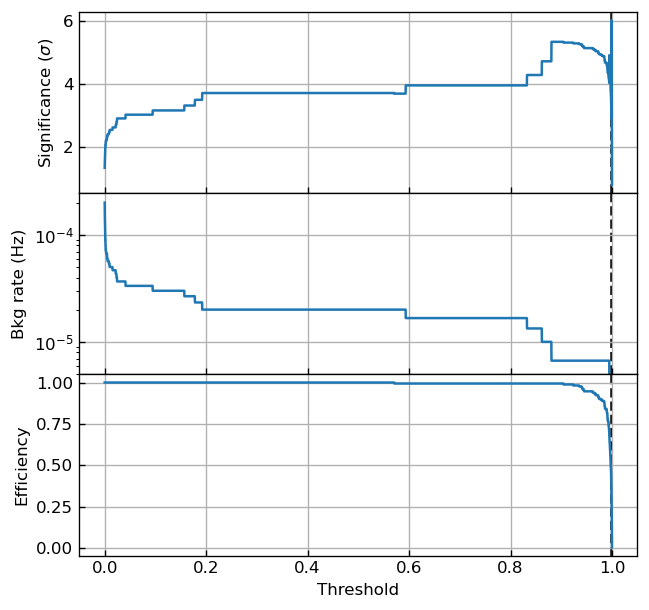

In [32]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_val,
                                                             y_val,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)

For training set

Max significance: 7.53 for threshold 0.9972 background rate 0.00e+00 and analysis efficiency 0.54


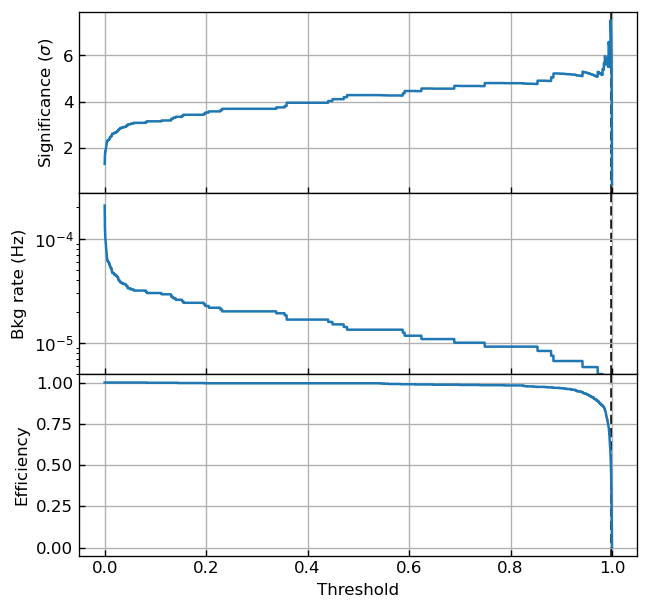

In [33]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_train,
                                                             y_train,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)
plt.savefig(f"{prefix:s}_perfomance_vs_thr.png")

Significance for test set with the threshold obtained from training set:

In [34]:
imax = np.argmax(significance)

In [35]:
y_pred = model.predict(X_val)

In [36]:
thr = threshold[imax]
#thr = 0.5
class_pred_val, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=thr)
print(thr)
sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

0.9972000000000001
3.8215270509725547 3.352132514262268e-06 0.5058823529411764


In [37]:
y_pred = model.predict(normalizer(sd.X_test))

In [41]:
thr = threshold[imax]
thr = 0.5
class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=thr)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(sd.y_test,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )

In [42]:
print(sig, bkg_rate, eff)

4.262981638138017 1.3407700629234085e-05 0.9906103286384976


Plot false positives for test set

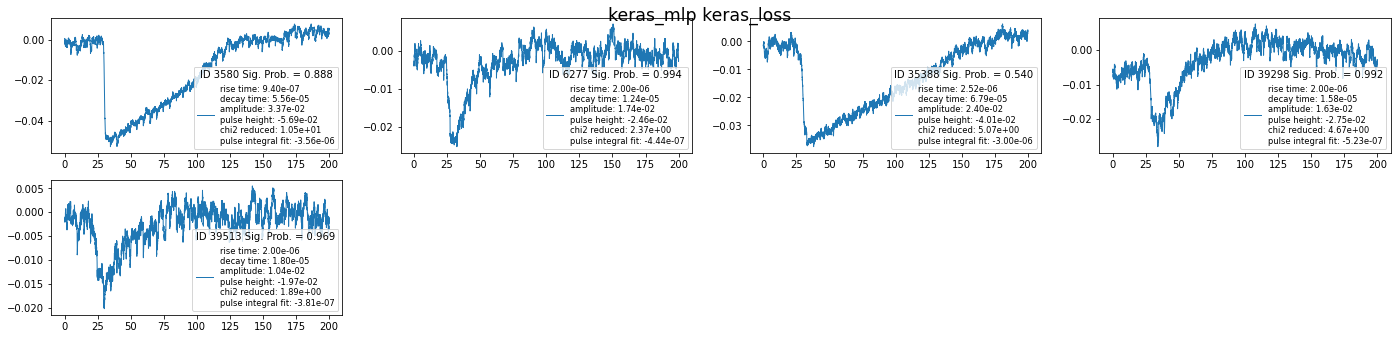

In [43]:
d = {}
d['y_test'] = sd.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = sd.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred, y_pred])}
d['classifier'] = "keras_mlp"

if fp.sum() < 50:
    ax = MLHyperParTuning.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=True, save_plot=False
    )
plt.savefig(f"{prefix:s}_{thr:.2f}_miss_ids.png")

### Learning curve

In [44]:
np.random.seed(42)
idx = np.arange(y_log.size)
np.random.shuffle(idx)
print(X_log[idx].shape)

sample_sizes, results_train, results_test = learning_curve(model, X_log[idx], y_log[idx], random_state=42, normalizer=normalizer, epochs=100)

(40412, 6)


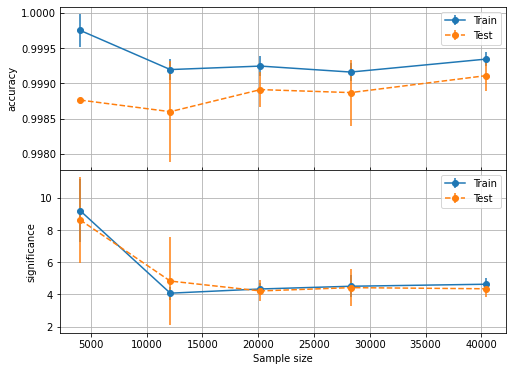

In [45]:
plt.figure(figsize=(8,6))
for i, k in enumerate(['accuracy', 'significance']):
    ax = plt.subplot(2,1,i+1)
    if not i:
        ax.tick_params(direction='in', labelbottom=False)
    plt.errorbar(sample_sizes, results_train[k].mean(axis=-1), yerr=np.sqrt(results_train[k].var(axis=-1)), marker='o', ls='-', color="C0", label="Train")
    plt.errorbar(sample_sizes, results_test[k].mean(axis=-1), yerr=np.sqrt(results_test[k].var(axis=-1)), marker='o', label="Test", ls='--', color="C1")
    plt.legend()
    ax.grid(which='both')
    ax.set_ylabel(k)
plt.subplots_adjust(hspace=0.)
ax.set_xlabel("Sample size")
plt.savefig(f"{prefix:s}_learning_curve.png")

In [46]:
model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

{'loss': 0.0027402015402913094,
 'tp': 680.0,
 'fp': 16.0,
 'tn': 25164.0,
 'fn': 3.0,
 'accuracy': 0.9992653727531433,
 'precision': 0.977011501789093,
 'recall': 0.9956076145172119,
 'auc': 0.99991774559021,
 'prc': 0.9957250952720642,
 'significance': 4.281110763549805}

### Repeat analysis over different folds

In [47]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b02bd160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4265bd040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:04:33.786584: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:33.786616: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:33.787856: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x71ec19ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 8.65 for threshold 0.9850 background rate 0.00e+00 and analysis efficiency 0.72
1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x4265371f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b107ef70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:04:58.149281: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:58.149409: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:58.149746: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29deab550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 6.91 for threshold 0.9991 background rate 0.00e+00 and analysis efficiency 0.46
2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29de775e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b0fe7ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:05:23.383205: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:23.383332: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:23.383345: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x2b136dc10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 7.12 for threshold 0.9816 background rate 0.00e+00 and analysis efficiency 0.49
3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x71eca6dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4265c8550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:05:48.178106: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:48.178664: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:48.178783: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29db8c280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 7.52 for threshold 0.9974 background rate 0.00e+00 and analysis efficiency 0.54
4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29dbd5ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b11fb9d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:06:13.909892: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06:13.910010: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06:13.910024: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0xaa69a0af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 8.02 for threshold 0.9862 background rate 0.00e+00 and analysis efficiency 0.62


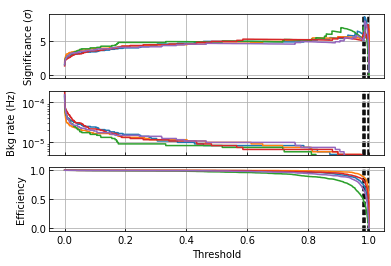

In [48]:
sig, br, ef = np.zeros(5), np.zeros(5), np.zeros(5)

for i in range(5):
    print(i)
    X_train, X_val, y_train, y_val = sd.get_split_with_test_set(m=i, n=0)
    
    # normalize the input data
    normalizer = Normalization(axis=-1)

    # adapt to training data
    normalizer.adapt(X_train)

    # normalize training data
    X_train = normalizer(X_train)
    X_val = normalizer(X_val)
    
    # calculate initial bias
    initial_bias, initial_loss = models.initial_output_bias(y_train)
    
    # the model
    model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4
                             )
    
    # fit the model
    models.train_model(model,
                       X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       X_val=X_val,
                       y_val=y_val,
                       class_weight=None
                      )
    
    # compute best threshold 
    ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                                 X_train,
                                                                 y_train,
                                                                 t_obs_hours=t_tot_hrs,
                                                                 N_tot=y_train.size + y_val.size + sd.y_test.size)
    
    imax = np.argmax(significance)
    y_pred = model.predict(X_val)
    class_pred_test, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=threshold[imax])

    sig[i], br[i], ef[i] = get_sig_bkg_rate_eff(y_val,
                                                y_pred,
                                                N_tot=y_train.size + y_val.size + sd.y_test.size,
                                                t_obs=t_tot_hrs * 3600.,
                                               # thr=threshold[imax]
                                                 thr=0.5
                                               )
    
    del model

In [50]:
mean = np.vstack([sig, br, ef]).mean(axis=1)
std = np.sqrt(np.vstack([sig, br, ef]).var(axis=1))
maximum = np.vstack([sig, br, ef]).max(axis=1)
minimum = np.sqrt(np.vstack([sig, br, ef]).min(axis=1))

print(mean)
print(std)
print(minimum)
print(maximum)

[5.42258357e+00 1.34085301e-05 9.78933609e-01]
[2.55901644e+00 1.01675213e-05 2.23698488e-02]
[1.80836806 0.         0.96730167]
[1.01578297e+01 2.68170601e-05 1.00000000e+00]
